# **Recomendador de películas**

**Práctica final `M5. Inteligencia artificial para la empresa`**

**Autor:** Jorge Galeano Maté

## Descripción

Construir un sistema de recomendación de películas que combine técnicas de filtrado colaborativo y procesamiento de lenguaje natural (LLM). El 
sistema permitirá a los usuarios describir la película que desean ver en lenguaje natural y recibir recomendaciones personalizadas.


## Datos

Se utilizarán tres archivos CSV par aconstruir el sistema:

- `ratings.csv`: valoraciones de los usuarios a las películas.

- `movies.csv`: información sobre las películas (título, géneros, etc.).

- `links.csv`: enlaces entre los ID de las películas en el conjunto de datos y los ID de IMDb.


## Instrucciones

### Paso 1: Construir un filtro colaborativo

Construye un filtro colaborativo haciendo uso de `ratings.csv`.

Puedes elegir entre:

- Item-to-item.

- User-to-user.

- Matriz factorizada con librería `surprise`.

- Red neuronal con `tensorflow` para simular la factorización de matrices.

_Nota: se valorará más la construcción de una red neuronal._

### Paso 2: Optimización del modelo

Optimizar los hiperparámetros del modelo de filtrado colaborativo. Probar diferentes modelos y seleccionar el que mejor rendimiento tenga en un conjunto de validación.

### Paso 3: Agente LLM para la selección de candidatos

- **3.1.** Recibir la descripción de la película deseada por el usuario (texto libre).

- **3.2.** Obtener el ID del usuario y, utilizando el filtro colaborativo, predecir las valoraciones para las películas no vistas.

- **3.3.** Seleccionar las 10 películas con las mejores valoraciones predichas.

- **3.4.** Extraer información de las 10 películas (géneros y sinopsis) utilizando la librería IMDb.

### Paso 4: Agente LLM para la explicación de la recomendación

Si alguna de las 10 películas coincide con la descripción del usuario, generar una explicación de por qué se recomienda esa película, considerando la descripción del usuario, la sinopsis y los géneros.

### Paso 5: Agente LLM para recomendación genérica

Si ninguna de las 10 películas coincide con la descripción del usuario, recomendar una película genérica que se ajuste a la descripción. Generar una explicación de por qué se recomienda.

---

# Pasos previos

## Configuración del entorno e importación de librerías

Configuramos el **entorno de trabajo** e **importamos todas las librerías necesarias**. 

In [1]:
# Entorno
import sys
import os

SYS_PATH = os.getenv('SYS_PATH')
if SYS_PATH:
    sys.path.append(SYS_PATH)
    from utils.model_functions import MatrixFactorization,\
        codificar_usuario, descodificar_usuario, codificar_pelicula, descodificar_pelicula
else:
    import warnings
    warnings.warn('SYS_PATH no está presente en archivo .env, es posible que no se importen funciones definidas por el usuario.', UserWarning)

# Análisis de datos
import pandas as pd
from skrub import TableReport
import numpy as np
import pickle

# Modelado
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import optuna

# Visualización
import matplotlib.pyplot as plt

2025-07-04 12:46:15.761497: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-04 12:46:15.818358: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EDA

In [2]:
df_links_init = pd.read_csv('./datos/links.csv')
df_movies_init = pd.read_csv('./datos/movies.csv')
df_ratings_init = pd.read_csv('./datos/ratings.csv')

In [3]:
TableReport(df_links_init)

Processing column   3 / 3


<TableReport: use .open() to display>

In [4]:
TableReport(df_movies_init)

Processing column   3 / 3


<TableReport: use .open() to display>

In [5]:
TableReport(df_ratings_init)

Processing column   4 / 4


<TableReport: use .open() to display>

Revisando los datos de los datasets, observamos varios puntos de interés:

- Solo existen 8 nulos en códigos de TMDb, pero ninguno de IMDb. Usaremos solo los códigos del segundo.

- Las distribuciones de los datos siguen patrones lógicos.

- Las valoraciones tienen un rango de 0.5 a 5, con incrementos de 0.5, y sin películas sin valorar.

Debido a que no hay valores ausentes significativos, los datos son correctos y el formato es consistente, no se considera necesario hacer limpieza.

---

# Paso 1: Construir un filtro colaborativo

## Preprocesamiento

Las capas de embedding en TensorFlow requieren índices consecutivos comenzando desde 0. Esta conversión es obligatoria para optimizar el uso de memoria y garantizar el funcionamiento correcto del modelo.

Los embeddings en TensorFlow necesitan recibir índices consecutivos desde 0, para optimizar el uso de memoria y garantizar el correcto funcionamiento del modelo. En este caso, los userId son consecutivos, pero comienzan desde 1; y los movieId no lo son.

Pasaremos usuarios y películas únicos a índices consecutivos para trabajar con la red neuronal. Asimismo, guardaremos un decodificador para pasar de nuevo de esos tokens a los códigos reales de usuarios y películas.

Trabajaremos sobre una copia para mantener el dataframe original antes de procesarlo para la red neuronal.

In [6]:
df_ratings = df_ratings_init.copy()

# Verificar userId
print('USER-ID:')
print(f'   Antes: Rango {df_ratings['userId'].min()} - {df_ratings['userId'].max()}')

# Crear mapeo consecutivo desde 0 en userId
user_idx, unique_users = pd.factorize(df_ratings['userId'])
df_ratings['users'] = user_idx

# Mostrar nuevo rango de users
print(f'   Después: Rango {df_ratings['users'].min()} - {df_ratings['users'].max()}')

# Verificar movieId
print('MOVIE-ID:')
print(f'   Antes: Rango {df_ratings['movieId'].min()} - {df_ratings['movieId'].max()}')

# Crear mapeo consecutivo desde 0 en movieId
movie_idx, unique_movies = pd.factorize(df_ratings['movieId'])
df_ratings['movies'] = movie_idx

# Mostrar nuevo rango de movies
print(f'   Después: Rango {df_ratings['movies'].min()} - {df_ratings['movies'].max()}')

USER-ID:
   Antes: Rango 1 - 610
   Después: Rango 0 - 609
MOVIE-ID:
   Antes: Rango 1 - 193609
   Después: Rango 0 - 9723


In [7]:
df_ratings.head()

,userId,movieId,rating,timestamp,users,movies
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [8]:
# Guardar dimensiones para red neuronal
n_users = len(unique_users)
n_movies = len(unique_movies)
print(f'Dimensiones para la red neuronal:')
print(f'   Número de usuarios: {n_users}')
print(f'   Número de películas: {n_movies}')

Dimensiones para la red neuronal:
   Número de usuarios: 610
   Número de películas: 9724


Guardamos los mapeos para codificar y descodificar los ID, ya que nosotros trabajamos con los ID originales, pero el modelo usará los índices consecutivos.

In [9]:
# Codificadores
user_to_idx = dict(zip(unique_users, range(len(unique_users))))
movie_to_idx = dict(zip(unique_movies, range(len(unique_movies))))

# Decodificadores
idx_to_user = dict(zip(range(len(unique_users)), unique_users))
idx_to_movie = dict(zip(range(len(unique_movies)), unique_movies))

Para usarlos más adelante, usaremos las funciones añadidas en `model_functions.py`, a las cuales pasaremos el ID o el index, y devolverá el que corresponda.

Adicionalmente, guardamos los mapeos en un archivo pickle para tenerlos disponibles en caso de ser necesarios.

In [10]:
with open('./models/mapeos.pkl', 'wb') as f:
    pickle.dump({
        'user_to_idx': user_to_idx,
        'idx_to_user': idx_to_user,
        'movie_to_idx': movie_to_idx,
        'idx_to_movie': idx_to_movie,
        'n_users': n_users,
        'n_movies': n_movies
    }, f)

## Análisis de densidad

De acara a utilizar una red neuronal, debemos verificar que la densidad de los datos sea suficiente para que se pueda entrenar correctamente.

Existe el problema del "cold start", en donde la red neuronal es incapaz de aprender embeddings de calidad cuando las muestras son pequeñas y los usuarios y películas tienen pocas interacciones. Si la densidad es demasiado baja (menor del 1%), la red neuronal no puede generalizar patrones correctamente-

Evaluamos la densidad para comprobar que esté por encima del 1%.

In [11]:
n_users = df_ratings['users'].nunique()
n_movies = df_ratings['movies'].nunique()
n_ratings = len(df_ratings)
sparsity = n_ratings / (n_users * n_movies)

print(f'Estado:')
print(f'   Usuarios: {n_users:,} | Películas: {n_movies:,} | Ratings: {n_ratings:,}')
print(f'   Densidad: {sparsity:.6f} ({sparsity*100:.2f}%)')

Estado:
   Usuarios: 610 | Películas: 9,724 | Ratings: 100,836
   Densidad: 0.017000 (1.70%)


Como podemos observar, la densidad está por encima del 1%, por lo que podemos proceder con la implementación de la red neuronal.

Por último, dividimos los datos en predictores y objetivo. A su vez, dividimos en grupos de entrenamiento y de test, mezclando los datos para que no se cojan los mismos.

In [12]:
X = df_ratings[['users', 'movies']].to_numpy()
y = df_ratings['rating'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

# Paso 2: Optimización del modelo

Para simular la matriz de factorización, debemos construir la red neuronal. Para ello, usamos la función creada en `model_functions.py` para construirla, lo aplicamos y compilamos el modelo para que use el **error cuadrático medio (MSE)** como métrica de pérdida, junto con el **optimizador Adam**.

Para optimizar los hiperparámetros, utilizamos la librería **Optuna**, que inteligentemente elige entre los parámetros dados los mejores para el modelo. Para evitar grandes costes y mucho tiempo de entrenamiento, probamos con 10 epochs para sacar los valores óptimos. Ajustamos algunos valores para el **embedding_size** (tamaño de los vectores), el **learning_rate**, el **batch_size** y el **reg_l2** (regularización L2).

In [20]:
def objective(trial):

    # Valores entre los que elegir
    embedding_size = trial.suggest_categorical('embedding_size', [8, 16, 32, 64])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-5])
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    reg_l2 = trial.suggest_categorical('reg_l2', [1e-6, 1e-4])

    # Modelo para compilar
    model = MatrixFactorization(n_users, n_movies, embedding_size, reg_l2)
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=learning_rate))

    # Entrenamiento del modelo con los hiperparámetros elegidos
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    return min(history.history['val_loss'])

# Realización del estudio de Optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=20)

print(f'\nMejores hiperparámetros: {study.best_params}')
print(f'Mejor MSE: {study.best_value:.4f}')

[I 2025-07-03 17:33:00,141] A new study created in memory with name: no-name-14453a3e-b616-4787-bb4e-60b24bfff8a7


[I 2025-07-03 17:33:29,129] Trial 0 finished with value: 12.914751052856445 and parameters: {'embedding_size': 16, 'learning_rate': 1e-05, 'batch_size': 128, 'reg_l2': 1e-06}. Best is trial 0 with value: 12.914751052856445.
[I 2025-07-03 17:34:08,208] Trial 1 finished with value: 12.756327629089355 and parameters: {'embedding_size': 64, 'learning_rate': 1e-05, 'batch_size': 128, 'reg_l2': 0.0001}. Best is trial 1 with value: 12.756327629089355.
[I 2025-07-03 17:34:22,847] Trial 2 finished with value: 12.905500411987305 and parameters: {'embedding_size': 8, 'learning_rate': 1e-05, 'batch_size': 128, 'reg_l2': 1e-06}. Best is trial 1 with value: 12.756327629089355.
[I 2025-07-03 17:34:45,237] Trial 3 finished with value: 12.846466064453125 and parameters: {'embedding_size': 16, 'learning_rate': 1e-05, 'batch_size': 128, 'reg_l2': 1e-06}. Best is trial 1 with value: 12.756327629089355.
[I 2025-07-03 17:35:49,614] Trial 4 finished with value: 12.633062362670898 and parameters: {'embedding_


Mejores hiperparámetros: {'embedding_size': 8, 'learning_rate': 0.001, 'batch_size': 64, 'reg_l2': 0.0001}
Mejor MSE: 0.8535


## Entrenamiento

Ahora, entrenamos el modelo con nuestros datos y los mejores hiperparámetros obtenidos. En este caso, aumentamos las epochs para que entrene mejor, y ajustamos un **early stopping** para que, si no mejoran las métricas en 10 pasadas, se detenga.

In [14]:
# Obtención de los mejores hiperparámetros
embedding_size, learning_rate, batch_size, reg_l2 = best_params.values()

# Compilación con dichos hiperparámetros
model = MatrixFactorization(n_users, n_movies, embedding_size, reg_l2)
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=learning_rate))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=60,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.7701 - val_loss: 1.1480
Epoch 2/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0898 - val_loss: 1.0244
Epoch 3/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9376 - val_loss: 0.9467
Epoch 4/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8719 - val_loss: 0.9261
Epoch 5/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8301 - val_loss: 0.8825
Epoch 6/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8048 - val_loss: 0.8866
Epoch 7/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7846 - val_loss: 0.8674
Epoch 8/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7734 - val_loss: 0.8768
Epoch 9/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7705 - val_loss: 0.8666
Epoch 10/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7626 - val_loss: 0.8543
Epoch 11/60
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7493 - val_loss: 0.8527
Epoch 12/60
1261/1261 ━━━━━━━━

Mostramos la gráfica de pérdida para ver el error producido a lo largo de cada pasada (epoch).

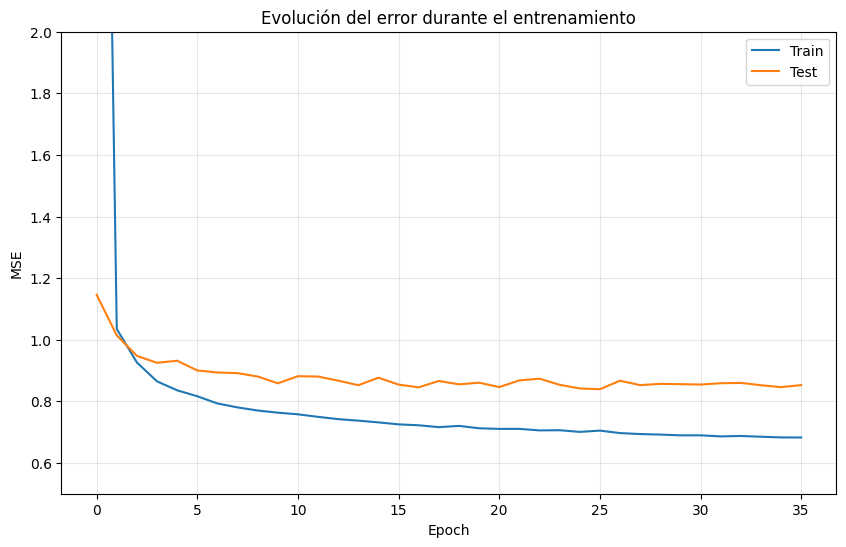

Train MSE final: 0.6825
Test MSE final: 0.8527
Test RMSE: 0.9234


In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Evolución del error durante el entrenamiento')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.ylim(0.5, 2.0)

plt.show()

final_train_mse = history.history['loss'][-1]
final_test_mse = history.history['val_loss'][-1]
print(f'Train MSE final: {final_train_mse:.4f}')
print(f'Test MSE final: {final_test_mse:.4f}')
print(f'Test RMSE: {np.sqrt(final_test_mse):.4f}')

Guardamos el modelo por si es necesario usarlo en el futuro. Usamos el formato `.keras`, que es el recomendado actualmente.

In [15]:
model.save('./models/factorization_matrix.keras')

# Paso 3: Agente LLM para selección de candidatos

- **3.1.** Recibir la descripción de la película deseada por el usuario (texto libre).

- **3.2.** Obtener el ID del usuario y, utilizando el filtro colaborativo, predecir las valoraciones para las películas no vistas.

- **3.3.** Seleccionar las 10 películas con las mejores valoraciones predichas.

- **3.4.** Extraer información de las 10 películas (géneros y sinopsis) utilizando la librería IMDb.

Cargamos el modelo guardado.

In [ ]:
model = load_model('./models/factorization_matrix.keras', custom_objects={
    'MatrixFactorization': MatrixFactorization
})

model.summary()

Model: "matrix_factorization"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 8)              │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1)              │           610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 8)              │        77,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 1)              │         9,724 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,020 (1.06 MB)

 Trainable params: 93,006 (363.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,014 (726.62 KB)

Primero, recibiremos la información del usuario, tanto de su ID como del texto libre.

In [ ]:
# Obtenemos un id de usuario aleatorio de prueba
usuario_prueba = df_ratings['users'].sample(1).iloc[0]

# Recibir descripción de película como texto libre
texto = input('¿Qué tipo de película te gustaría ver?: ')

A continuación, obtenemos las películas que el usuario no ha visto y hacemos la predicción con el modelo.

In [ ]:
df_movies = df_movies_init.copy()

# Obtenemos las películas que no ha visto
peliculas_vistas = df_ratings[df_ratings['users'] == usuario_prueba]
peliculas_no_vistas = df_movies[~df_movies['movieId'].isin(peliculas_vistas['movieId'].to_numpy())]['movieId']
peliculas_no_vistas = list(set(peliculas_no_vistas).intersection(set(movie_to_idx.keys())))

# Pasamos a tokens para poder usar en el modelo
peliculas_no_vistas_idx = [[codificar_pelicula(x, movie_to_idx)] for x in peliculas_no_vistas]

# Predecimos ratings de películas no vistas
usuario_prueba_idx = codificar_usuario(usuario_prueba, user_to_idx)
user_movie_array = np.hstack(
    ([[usuario_prueba_idx]] * len(peliculas_no_vistas_idx), peliculas_no_vistas_idx)
)

ratings = model.predict(user_movie_array).flatten()

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
